# Wikibase Agent <a target="_blank" href="https://colab.research.google.com/github/dowhiledev/nomos/blob/main/cookbook/wikibase_agent.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> This cookbook is inspired by the [Langchain's Implementation of WikiBase Agent](https://github.com/langchain-ai/langchain/blob/master/cookbook/wikibase_agent.ipynb)

This notebook demonstrates a very simple wikibase agent that uses sparql generation. Although this code is intended to work against any
wikibase instance, we use http://wikidata.org for testing.

## Setup

For this cookbook, we only require to install the `nomos` package. rest of the dependancies are already installed in the environment.

In [ ]:
!pip install nomos -U

## Tools
We will require 3 tools for this simple agent:
- `item_lookup`: for finding the q-number of an item
- `property_lookup`: for finding the p-number of a property
- `run_sparql`: for running a sparql query

We will create these tools in this section. (These are straight from the [Langchain's Implementation of WikiBase Agent](https://github.com/langchain-ai/langchain/blob/master/cookbook/wikibase_agent.ipynb) with minor modifications)

In [1]:
from typing import Any, List, Optional

import requests

def get_nested_value(o: dict, path: list) -> any:
    current = o
    for key in path:
        try:
            current = current[key]
        except (KeyError, IndexError):
            return None
    return current


def vocab_lookup(
    search: str,
    entity_type: str = "item",
    url: str = "https://www.wikidata.org/w/api.php",
    user_agent_headers: Optional[str] = None,
    sqriprofile: Optional[str] = None,
) -> str:
    headers = {"Accept": "application/json"}
    if user_agent_headers:
        headers["User-Agent"] = user_agent_headers

    assert entity_type in ["item", "property"], "entity_type must be 'item' or 'property'"
    srnamespace = 0 if entity_type == "item" else 120
    sqriprofile = sqriprofile or "classic_noboostlinks" if entity_type == "item" else "classic"

    params = {
        "action": "query",
        "list": "search",
        "srsearch": search,
        "srwhat": "text",
        "format": "json",
        "type": entity_type,
        "srlimit": 1,
        "srnamespace": srnamespace,
        "sqriprofile": sqriprofile,
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code != 200:
        raise Exception(f"Error {response.status_code}: {response.text}")
    title = get_nested_value(response.json(), ["query", "search", 0, "title"])
    assert title, f"I couldn't find any {entity_type} for '{search}'. Please rephrase your request and try again"
    return str(title).split(":")[-1]


def run_sparql_advanced(
    query: str,
    url="https://query.wikidata.org/sparql",
    user_agent_header: Optional[str] = None,
) -> Any: # noqa
    headers = {"Accept": "application/json"}
    if user_agent_header:
        headers["User-Agent"] = user_agent_header

    response = requests.get(
        url, headers=headers, params={"query": query, "format": "json"}
    )

    if response.status_code != 200:
        raise Exception(f"Error {response.status_code}: {response.text}")
    results = get_nested_value(response.json(), ["results", "bindings"])
    return results

In [2]:
print(vocab_lookup("Malin 1"), vocab_lookup("instance of", entity_type="property"))

Q4180017 P7125


In [3]:
print(vocab_lookup("Ceci n'est pas un q-item")) # Should raise an error since the item does not exist

AssertionError: I couldn't find any item for 'Ceci n'est pas un q-item'. Please rephrase your request and try again

In [4]:
run_sparql_advanced("SELECT (COUNT(?children) as ?count) WHERE { wd:Q1339 wdt:P40 ?children . }")

[{'count': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
   'type': 'literal',
   'value': '20'}}]

These tools have unnecssary attributes we dont want the agent to interact with so we will remove them by creating a simple wrapper functions.

In [5]:
def run_sparql(query: str) -> List[dict]:
    """Gets the results of a SPARQL query from Wikidata."""
    return run_sparql_advanced(query)

def item_lookup(search: str) -> str:
    """Useful for when you need to know the q-number for an item"""
    return vocab_lookup(search, entity_type="item")

def property_lookup(search: str) -> str:
    """Useful for when you need to know the p-number for a property"""
    return vocab_lookup(search, entity_type="property")

## Agent

Here will create a simple agent that uses the tools and answers the question. We will use `Nomos` to create the agent and run it.
For the time being. we will create only a single step agent.

In [6]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")
os.environ["ENABLE_NOMOS_LOGGING"] = "true"

In [7]:
from nomos import *
from nomos.llms import LLMConfig

step_instructions = """
Answer the following questions by running a sparql query against a wikibase where the p and q items are 
completely unknown to you. You will need to discover the p and q items before you can generate the sparql.
Do not assume you know the p and q items for any concepts. Always use tools to find all p and q items.
After you generate the sparql, you should run it. The results will be returned in json. 
Summarize the json results in natural language.

You may assume the following prefixes:
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>

When generating sparql:
* Try to avoid "count" and "filter" queries if possible
* Never enclose the sparql in back-quotes
"""

start_step = Step(
    step_id="start",
    description=step_instructions,
    available_tools=["run_sparql", "item_lookup", "property_lookup"],
)

llm = LLMConfig(
    provider="openai",
    model="gpt-4o-mini",
).get_llm()

agent = Agent(
    name="Wikidata SPARQL Agent",
    steps=[start_step],
    start_step_id="start",
    tools=[run_sparql, item_lookup, property_lookup],
    llm=llm,
)

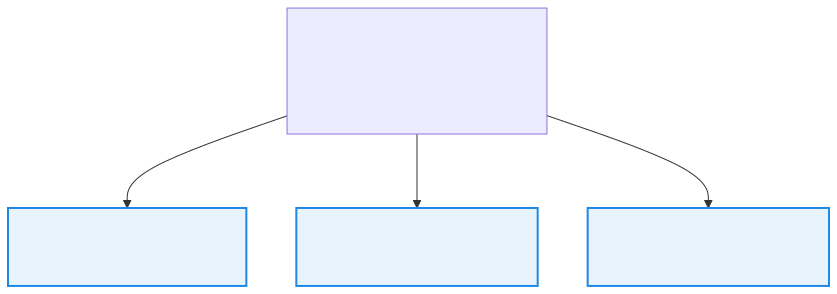

In [8]:
agent.display()

In [9]:
res = agent.next("How many children did J.S. Bach have?")
res.decision.response

'Johann Sebastian Bach had 20 children.'

In [10]:
res = agent.next("What is the Basketball-Reference.com NBA player ID of Hakeem Olajuwon?")
res.decision.response

"The Basketball-Reference.com NBA player ID for Hakeem Olajuwon is 'hakeem-olajuwon-1'."

You can also maintain sessions for continuous conversations.

In [11]:
session = agent.create_session()
res = session.next("What is the Basketball-Reference.com NBA player ID of Hakeem Olajuwon?")
print(res.decision.response)
res = session.next("How old he was when he retired?")
print(res.decision.response)

The Basketball-Reference.com NBA player ID of Hakeem Olajuwon is 'o/olajuha01'.
I'm sorry, but I was unable to find the retirement year of Hakeem Olajuwon. Therefore, I cannot calculate his age when he retired.
